## 1. Importing the dataset
<p>Insurance company is planning a marketing campaign to sell accident insurance to their existing customers. For a good cost-benefit ratio advertising letters should be sent to customers with a high propensity to buy only.</p>
<p>To identify those customers you are asked to develop a logistic regression model predicting how likely a customer is to buy this insurance product. Therefore you are given a dataset with presumably relevant features describing the customers and their contractual relationship to Allianz (as known at the end of 2019) together with the labels whether they contracted an accident insurance in 2020 or not. The dataset consists of a sample of ten thousand customers. Later, your model would be applied to all current customers that come into consideration for the marketing campaign and only those with the highest predicted propensity to buy would be addressed.</p>
<hr>
<p><strong>Note: the dataset is based upon a non-representative sample of real data, but (for the purposes of data security) is strongly modified in various ways so that conclusions drawn from the exploratory part and the models do not reflect reality.</strong></p>

In [1]:
# Import pandas using the usual alias
import pandas as pd

# Read in the semi-colon separated data from datasets/NEW_BUSINESS_ACCIDENT_10000.csv
propensity_data = pd.read_csv('NEW_BUSINESS_ACCIDENT_10000.csv', sep=';')

# Print out the first 5 lines of the dataset
propensity_data.head()

,id,new_business,age,number_of_contracts,property,life,health,premium_customer,premium_household,sales_channel,new_business_py,self_employed,gender_male
0,1,0,59,1,1,0,0,164.00,1976.11,other,none,0,1
1,2,0,59,1,0,1,0,272.18,272.18,tied_agend,none,0,0
2,3,0,53,2,0,1,1,1298.28,20160.83,tied_agend,none,0,0
3,4,0,30,1,0,0,1,5.13,5.13,tied_agend,none,0,1
4,5,0,43,4,1,0,1,710.61,710.61,tied_agend,p,1,0


## 2. Exploring the dataset
<p>Here are the details of the dataset you just imported.</p>
<ul>
<li><code>id</code>: identity number of the customer</li>
<li>target is <code>new_business</code>: dichotomous variable indicating whether the customer bought an accident insurance within the following year (1: yes, 0: no)</li>
<li><code>age</code>: age of the customer in full years (numerical, ranging from 30 to 70)</li>
<li><code>number_of_contracts</code>: number of insurance policies the customer has with Allianz Germany already (numerical/ discrete)</li>
<li><code>property</code>: dichotomous feature indicating whether the customer holds policies from the field of P&amp;C (property and casualty) (1: yes, 0: no)</li>
<li><code>life</code>: dichotomous feature indicating whether the customer holds policies from the field of life insurance (1: yes, 0: no)</li>
<li><code>health</code>: dichotomous feature indicating whether the customer holds policies from the field of health insurance (1: yes, 0: no)</li>
<li><code>premium_customer</code>: annual premium the customer is paying (numerical/ quasi-continuous)</li>
<li><code>premium_household</code>: annual premium of all Allianz Germany customers living in the household of the customer including the customer himself (numerical/ quasi-continuous)</li>
<li><code>sales_channel</code>: sales channel through which the customer concluded his insurance policies (nominal/ multi-categorical)</li>
<li><code>gender_male</code>: dichotomous feature indicating whether the customer is male (1: yes, 0: no)</li>
<li><code>new_business_py</code>: business field(s) of new insurance contracts concluded by the customer within the prior year (nominal/ multi-categorical, none: no new business, p: new business from the field of P&amp;C only, p+: new business from the field of P&amp;C and at least one other field, lh: new business from the field of life, health or both)</li>
<li><code>self_employed</code>: dichotomous feature indicating whether the customer is self-employed (1: yes, 0: no)</li>
</ul>
<hr>
<p>Instead of starting directly with the development of the predictive model, you should first familiarize yourself with the data and get an understanding for the relationships between the variables. Having a look at the correlation matrix is a good start. It will give you a first impression of the predictive power of your numerical features and will also allow you to identify highly correlated features. Strong collinearity should be avoided when building a logistic regression model as it may hinder the convergence of your model and makes the coefficients less meaningful and reliable. But note that correlation only measures the linear relationship!</p>
<p>Correlation matrices can also quickly become confusing, especially if there are many variables. Color highlighting of strong correlations can then be very helpful. This can be done by using a heatmap&mdash;have a try! Do some coefficients attract your attention? Keep your observations in mind, we will get back to them in later tasks.</p>

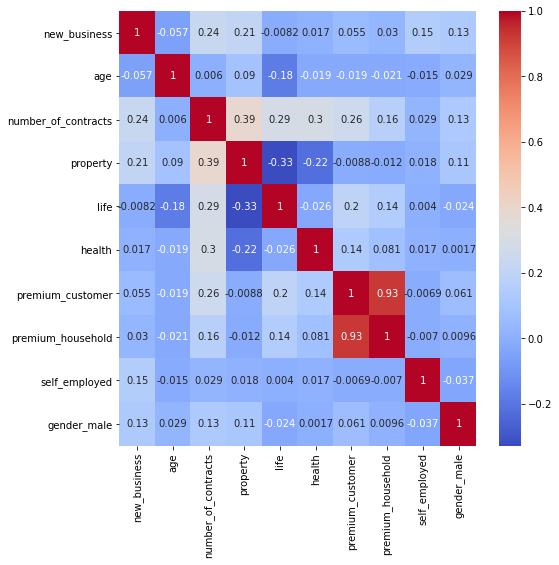

In [2]:
# Import seaborn and matplotlib.pyplot using the usual aliases
import seaborn as sns
import matplotlib.pyplot as plt 

# Drop the ID column from the first axis
no_id = propensity_data.drop(columns=['id'], axis=1)

# Calculate a correlation matrix of all columns of no_id
corr_matrix = no_id.corr()

# Draw a heatmap of corr_matrix, with annotations, using the 'coolwarm' colormap
plt.figure(figsize = (8, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Display the plot
plt.show()

## 3. Visualizing lines of business
<p>The previous correlation heatmap revealed several interesting things.</p>
<ul>
<li><code>premium_customer</code> and <code>premium_household</code> are highly linearly correlated, so we will only need to include one of them in our model. Since <code>premium_household</code> is less strongly correlated with <code>number_of_contracts</code>, we will choose to only include <code>premium_household</code> in our model and drop <code>premium_customer</code>.</li>
<li>There is moderate correlation between <code>property</code>, <code>life</code> and <code>health</code>. This can be avoided by combining them and creating a new feature, <code>lines_of_business</code>.</li>
<li>There is low correlation between <code>age</code> and the target variable <code>new_business</code>. We should explore this relationship using a line plot.</li>
</ul>
<p>For now, let's concentrate on the three lines of business: property, life, and health. These indicate whether the customer holds a product from the according line of business at Allianz.</p>
<p>Instead of considering these features separately, you can combine them in a new feature, <code>lines_of_business</code>, reflecting the product mix of the customer and thus capture even more information. While tree-based models capture interaction effects between features automatically, logistic regression models do not. You can improve your model by adding interaction terms manually. To check the relationship between the newly built feature and the propensity to buy an accident insurance, create a barplot visualizing the proportion of customers with new business for each category. <em>Do you think the interaction terms would add value to your model?</em></p>

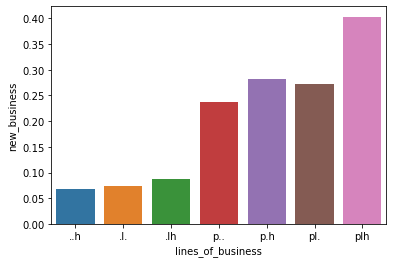

In [3]:
# Import numpy using the usual alias
import numpy as np

# This code returns "p" where the property column is True and "." otherwise
p = np.where(propensity_data["property"], "p", ".") 

# Return "l" where the life column is True and "." otherwise
l = np.where(propensity_data['life'], 'l', '.')

# Return "h" where the health column is True and "." otherwise
h = np.where(propensity_data['health'], 'h', '.')

# Add the character arrays p, l, and h together
propensity_data["lines_of_business"] = np.char.add(np.char.add(p, l), h)

# For each lines_of_business group, calculate the proportion of new business
prop_new_business_by_lines_of_business = propensity_data.groupby('lines_of_business')['new_business'].mean()

# Reset the index of prop_new_business_by_lines_of_business
prop_new_business_by_lines_of_business_data = prop_new_business_by_lines_of_business.reset_index()
#prop_new_business_by_lines_of_business_data.head()

# Draw a bar plot of the proportion of new_business vs. lines_of_business and display it
ax=sns.barplot(data =prop_new_business_by_lines_of_business_data, x='lines_of_business', y='new_business' )
#ax = plt.bar(prop_new_business_by_lines_of_business_data['lines_of_business'], prop_new_business_by_lines_of_business_data[new_business])
plt.show()

In [5]:
propensity_data.head()

,id,new_business,age,number_of_contracts,property,life,health,premium_customer,premium_household,sales_channel,new_business_py,self_employed,gender_male,lines_of_business
0,1,0,59,1,1,0,0,164.00,1976.11,other,none,0,1,p..
1,2,0,59,1,0,1,0,272.18,272.18,tied_agend,none,0,0,.l.
2,3,0,53,2,0,1,1,1298.28,20160.83,tied_agend,none,0,0,.lh
3,4,0,30,1,0,0,1,5.13,5.13,tied_agend,none,0,1,..h
4,5,0,43,4,1,0,1,710.61,710.61,tied_agend,p,1,0,p.h


## 4. Visualizing gender and employment status
<p>Creating <code>lines_of_business</code> gave you further insights on the influence of a customers current product lines on the target variable you wouldn't have known when looking at property, health, and life separately.</p>
<p>You know now that customers holding Property and Casualty (P&amp;C) policies are most likely to purchase an accident insurance. Since the bar plot showed combinations, you also know that the likelihood of buying accident insurance is even higher if they additionally hold policies from the other fields. Customers with all three types (P, L and H) are most likely, with 40% of these customers buying accident insurance in the next year. Let's keep exploring variables.</p>
<p>Don't hesitate to try unintuitive combinations of variables. How about gender and employment status? The correlation matrix told us about the tendency of males and self-employed customers are more likely to buy an accident insurance.</p>
<p><em>Would it be valid to assume that self-employed men have the highest likelihood to buy an accident insurance product?</em> Let's check, you might be surprised.</p>
<p>This time it's your turn to create the combination. Use the same method shown to you in the previous task.</p>

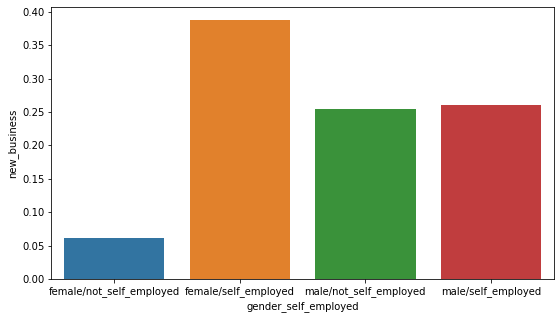

In [4]:
# Return "self_employed" where self_employed column is True, and "not_self_employed" otherwise
e = {1: 'self_employed', 0:'not_self_employed'}
propensity_data["self_employment_status"] = propensity_data['self_employed'].map(e)

# Return "male" where gender_male column is True, and "female" otherwise
g= {1: 'male', 0:'female'}
propensity_data["gender"] = propensity_data['gender_male'].map(g)

# Combine gender and self-employment status into a single feature
propensity_data["gender_self_employed"] = propensity_data['gender'] + "/" + propensity_data['self_employment_status']

# For each gender-status group, calculate the proportion of new business
prop_new_business_by_gender_self_employment = propensity_data.groupby('gender_self_employed')['new_business'].mean()

# Reset the index of prop_new_business_by_gender_self_employment
prop_new_business_by_gender_self_employment_data = prop_new_business_by_gender_self_employment.reset_index()

# Draw a bar plot of the proportion of new business vs. gender-status group
plt.figure(figsize = (9, 5))
ax = sns.barplot(data = prop_new_business_by_gender_self_employment_data, x='gender_self_employed', y='new_business' )
plt.show()

In [5]:
propensity_data.head()

,id,new_business,age,number_of_contracts,property,life,health,premium_customer,premium_household,sales_channel,new_business_py,self_employed,gender_male,lines_of_business,self_employment_status,gender,gender_self_employed
0,1,0,59,1,1,0,0,164.00,1976.11,other,none,0,1,p..,not_self_employed,male,male/not_self_employed
1,2,0,59,1,0,1,0,272.18,272.18,tied_agend,none,0,0,.l.,not_self_employed,female,female/not_self_employed
2,3,0,53,2,0,1,1,1298.28,20160.83,tied_agend,none,0,0,.lh,not_self_employed,female,female/not_self_employed
3,4,0,30,1,0,0,1,5.13,5.13,tied_agend,none,0,1,..h,not_self_employed,male,male/not_self_employed
4,5,0,43,4,1,0,1,710.61,710.61,tied_agend,p,1,0,p.h,self_employed,female,female/self_employed


## 5. Visualizing customer age
<p>The previous bar plot showed that while women overall are less likely to buy a new insurance than men are, self-employment makes a big difference with women. While the self-employment status does not make a difference for the subgroup of the male customers, women that are self-employed have a much higher propensity to buy, even higher than men. Therefore it might be good idea to fit the logistic regression with the interaction term instead of adding gender and self-employment separately.</p>
<p>Now that you had a look at some interactions, let's have a look at a single feature. For many behavioral questions age is a highly predictive attribute. However the correlation matrix from the second task showed us that the linear correlation between a customer's age and the purchase of an accident insurance policy is not very high. There are two possible reasons for this: either age isn't related to our target variable, or the relationship is nonlinear. Let's plot the mean number of customers with new business per age group to find out which of these is correct!</p>
<p>Depending on the outcome you should either exclude age when building your model or consider applying a transformation or similar since including age in a logistic regression model would only lead to the estimation of a monotone effect and would therefore not result in a good fit.</p>

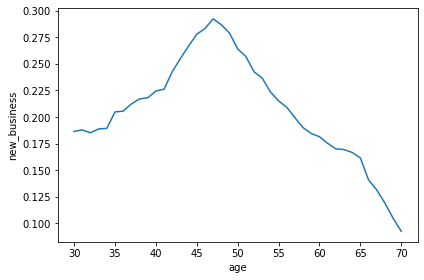

In [33]:
# For each age group, calculate the proportion of new business, then reset the index
prop_new_business_by_age = propensity_data.groupby('age')['new_business'].mean().reset_index()

# Draw a line plot of the proportion of new business vs. age
ax = sns.lineplot(data = prop_new_business_by_age, x='age', y='new_business', ci=None)
plt.show()

## 6. Preparing the first model
<p>The curve of new business versus age revealed a non-monotone relationship which looks almost parabolic. To capture this relation you could include an age squared term to your model in addition to <code>age</code>.</p>
<p>Until now you explored a couple of features in your dataset and gained interesting insights which will help you with developing a good model. In practice you should explore all available features. However, since this would be too lengthy for this project, you'll stop data exploration at this point and will begin with the building process. Start with a simple model that does not yet include the newly derived features and the squared age term. Later, you will build a second model that includes these features and compare the two to see how fit and performance are improved. </p>
<p>For both models you will use a transformed version of <code>premium_household</code> because the variable is heavily tailed and only weakly correlated with the target. To get a well-distributed feature with an approximately monotone effect on propensity to buy, extreme values were truncated and a logarithmic transformation was applied. This code is provided for you. The other variables can be used more or less as they are. You only have to take care of the categorical variables and convert them into dummy variables as regression models can only handle numeric variables.</p>
<p>Then your dataset is almost ready for training. All you have to do is split it into a train and a test dataset to be able to check the performance of your fitted model on unseen data.</p>

In [7]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Select the new_business column as the response
response = propensity_data['new_business']

# Log of premium household feature provided
propensity_data["premium_household_log"] = np.log10(
    np.minimum(np.maximum(propensity_data["premium_household"], 1), 50000))

# These features will be included
model1_features = propensity_data[
    ["age", "number_of_contracts", "gender_male", "self_employed", "sales_channel",
     "property", "health", "life", "new_business_py", "premium_household_log"]
]

# Get dummy variables for the features
model1_dummies = pd.get_dummies(model1_features, drop_first=True)

# Split the dataset into training and testing sets with a test size of 30%, 
# using 42 as the random seed and stratified by the response
model1_X_train, model1_X_test, model1_y_train, model1_y_test = train_test_split(model1_dummies, response, test_size=0.3, random_state=42, stratify=response)



premium_household continuous variable is transformed This is done when the variables span several orders of magnitude. Income is a typical example: its distribution is "power law", meaning that the vast majority of incomes are small and very few are big. extreme values in exponential distribution are by definition very rare. Therefore data which spans many orders of magnitude is usually power law. This type of "fat tailed" distribution is studied in logarithmic scale because of the mathematical properties of the logarithm.

 Logarithm naturally reduces the dynamic range of a variable so the differences are preserved while the scale is not that dramatically skewed. Imagine some people got 100,000,000 loan and some got 10000 and some 0. Any feature scaling will probably put 0 and 10000 so close to each other as the biggest number anyway pushes the boundary. Logarithm solves the issue.


When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data

import numpy as np
x = [1, 2, 3, 4, 5]
y = np.log(x)
y

## 7. Training the first logistic regression model
<p>Now you are ready to fit the first logistic regression model. It can then be used to make a decision about which of our current customers should be addressed within the marketing campaign. But before that, you better take a look at the fit and performance of the model and try to improve it. </p>
<p>Fitting is done on the training set only. Checking the fit for individual independent variables like <code>age</code> can be performed on the training set, too. However, predictive power is measured on the test set only!  </p>

In [8]:
# Import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression object using 'newton-cg' as solver
log_reg1 = LogisticRegression(solver='newton-cg')

# Fit the logistic regression model to model1_X_train and model1_y_train 
log_reg1.fit(model1_X_train, model1_y_train)

LogisticRegression(solver='newton-cg')

## 8. Evaluating the first model
<p>With the test data set, you can now examine the predictive power of your model. Predict the probabilities of purchasing an accident insurance for the customers in the test dataset. Then use these probabilities to create an ROC plot and calculate the area under the curve. These measures will give you a first impression on how good the model would perform when using it for the marketing campaign.</p>

/home/tm/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


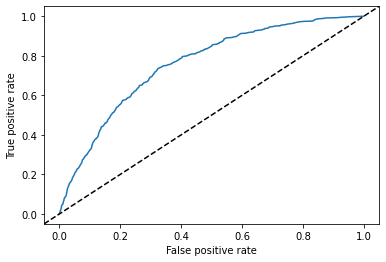

The AUC for Model 1 is 0.76.


In [9]:
# Import roc_curve and roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_curve, roc_auc_score

# Predict the probabilities of buying on the test dataset
model1_prediction_probs = log_reg1.predict_proba(model1_X_test)[:,1]

# Calculate ROC curve
fpr1, tpr1, thresholds1 = roc_curve(model1_y_test, model1_prediction_probs)

# Draw line plot of true positive rate vs. false positive rate
ax = sns.lineplot(fpr1, tpr1, ci=None)

# This code adds a dashed line along y = x
ax.axline([0, 0], slope=1, linestyle='--', color='k')

# This code labels the axes and displays the plot
ax.set(xlabel='False positive rate', ylabel='True positive rate')
plt.show()

# Calculate the AUC
auc1 = roc_auc_score(model1_y_test, model1_prediction_probs)
print(f"The AUC for Model 1 is {auc1:.2f}.")

## 9. Using derived variables in a second model
<p>Your model seems to have reasonable predictive power. Now try to improve its performance by including the features you built during exploration.</p>
<p>By combining the information about the customers product ownership in one variable you discovered that customers holding at least one insurance product in each of the three business lines (P, L and H) are most likely to buy an accident insurance. You also saw earlier that the proportion of new business seemed to be different for women when they are self employed or not, but didn't see that change for men. This indicated that there is some sort of interaction between gender and self-employment. Moreover, you saw that the curve of new business versus age looked almost parabolic. This effect can be captured better by including an extra age squared term. </p>
<p>Make use of these findings by including the interactions in your model.</p>
<p>To ensure comparability with the first model choose the same test size and random seed when splitting the dataset.</p>

In [10]:
# Create an age squared column
propensity_data["age_squared"] = propensity_data['age']**2

# This model also includes age_squared and interactions between gender/self-employment and lines of business
model2_features = propensity_data[
    ["age", "age_squared", "number_of_contracts", "gender_self_employed", 
     "sales_channel", "lines_of_business", "new_business_py", "premium_household_log"]
]

# Get dummy variables for the features
model2_dummies = pd.get_dummies(model2_features, drop_first=True)

# Split the dataset into training and testing sets with a test size of 30%, 
# using 42 as the random seed and stratified by the response
model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_dummies, response, test_size=0.3, random_state=42, stratify=response)



# Create a LogisticRegression object using 'newton-cg' as solver
log_reg2 = LogisticRegression(solver='newton-cg')

# Fit the logistic regression model to model2_X_train and model2_y_train 
log_reg2.fit(model2_X_train, model2_y_train)

# Predict the probabilities of buying on the test dataset
model2_prediction_probs = log_reg2.predict_proba(model2_X_test)[:,1]

## 10. Comparing fit of age on training set
<p>You included the age squared term in the second model to better capture the almost parabolic effect of age on propensity to buy. Check if this worked and if there is a visible improvement between model 1 and 2.</p>
<p>You can visualize the fit by comparing the mean of predicted probabilities on the training set per age group for model 1, model 2 and the true proportion. </p>
<p>Combining all information in one plot helps with comparison. This can be easily implemented with Seaborn if the dataset contains all relevant data and is in the right format.  </p>

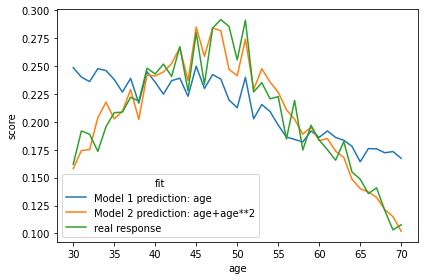

In [43]:
# Predict the probabilities of buying on the training dataset for Model 1
model1_scores_train = log_reg1.predict_proba(model1_X_train,)[:,1]

# Do the same for Model 2
model2_scores_train = log_reg2.predict_proba(model2_X_train,)[:,1]

# Complete the dictionary to fill the DataFrame
real_age_scores = pd.DataFrame.from_dict({
    # Get the ages from Model 1 training dataset
    'age': model1_X_train['age'], 
    # Get the Model 1 training responses
    'score': model1_y_train, 
    'fit': 'real response'
})

# Complete the dictionary to fill the DataFrame
model1_age_scores = pd.DataFrame.from_dict({
    # Get the ages from Model 1 training dataset
    'age': model1_X_train['age'], 
    # Get the Model 1 predicted probabilities
    'score': model1_scores_train, 
    'fit': 'Model 1 prediction: age'
})

# Complete the dictionary and convert to a DataFrame
model2_age_scores = pd.DataFrame.from_dict({
    # Get the ages from Model 2 training dataset
    'age': model2_X_train['age'], 
    # Get the Model 2 predicted probabilities
    'score': model2_scores_train, 
    'fit': 'Model 2 prediction: age+age**2'
})

# From real_age_scores append model1_age_scores then append model2_age_scores
age_scores = (real_age_scores.append(model1_age_scores)).append(model2_age_scores)

# Group `age_scores` by age and fit, select the score column, 
# calculate the mean, and reset the index
modelfit_age = age_scores.groupby(['age', 'fit'])['score'].mean().reset_index()

# Using modelfit_age, draw a line plot of score vs. age colored by fit
ax = sns.lineplot(data=modelfit_age, hue='fit', x='age', y='score', ci=None)
plt.show()

## 11. Comparing model performance
<p>The previous plot showed that model 2 actually captured the almost parabolic effect of age on the propensity to buy very well while model 1 only estimated a monotone effect. Now check if the predictive power has improved in addition to the fit. Compare the ROC curves of the two models by drawing both curves in one plot and calculate the AUC values. </p>

AUC1 = 0.758
AUC2 = 0.784


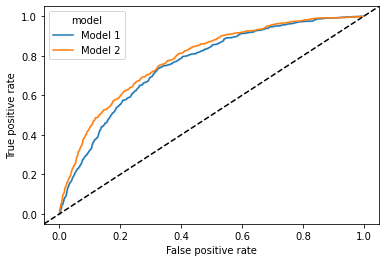

In [11]:
# Predict the probabilities of buying on the Model 2 test dataset
model2_prediction_probs = log_reg2.predict_proba(model2_X_test)[:,1]

# Calculate the ROC curve using Model 2
fpr2, tpr2, thresholds2 = roc_curve(model2_y_test, model2_prediction_probs)

# This creates a DataFrame of ROC data from Model 1
roc_data1 = pd.DataFrame.from_dict({
    'fpr': fpr1, 
    'tpr': tpr1, 
    'model': 'Model 1'
})
# Create a DataFrame of ROC data from Model 2
roc_data2 = pd.DataFrame.from_dict({
    'fpr':fpr2,
    'tpr':tpr2,
    'model': 'Model 2'
})


# From the Model 1 ROC data, append the Model 2 ROC data
roc_data = roc_data1.append(roc_data2)

# Using roc_data, draw a line plot of true +ve rate vs. false +ve rate colored by model 
ax = sns.lineplot(data=roc_data, x='fpr', y='tpr', hue ='model')

# Add diagonal and labels to the x and y axes
ax.set(xlabel='False positive rate', ylabel='True positive rate')
ax.axline([0, 0], slope=1, linestyle='--', color='black')

# Calculate AUC score of Model 2
auc2 = roc_auc_score(model2_y_test, model2_prediction_probs)

# Print AUC values for both models
print(f"AUC1 = {auc1:.3f}")
print(f"AUC2 = {auc2:.3f}")

## 12. Examining lift
<p>As the exploration of the data above suggested, including the derived features improved the predictive power of your logistic regression. Model 2 is outperforming Model 1 at almost every classification threshold. For example, the AUC value increased from <code>0.758</code> to <code>0.784</code>.</p>
<p>These metrics provide a comprehensive measure of model performance across all data points. For this marketing campaign however, you are only interested in detecting the (let's say) 10% of customers with the highest propensity to buy. That is, you only care about a model that performs well for the top-score sector. Therefore, you will now take a final look at the 10% lift of your models and compare them.</p>
<p>Lift is a measure of the effectiveness of a predictive model. It is very popular in marketing analytics and quantifies how much better you can expect to perform with the predictive model compared to without the model. </p>
<p>The 10% lift is calculated as the ratio between the true proportion of customers with new business among the 10% customers with the highest propensity to buy and the overall proportion of customers with new business. For example, if the 10% lift of our model is 2, picking the top 10% customers with the highest scores from this model would result in a subgroup whose propensity to buy is 2 times higher than the overall average. We could then conclude that the marketing campaign would benefit from our prognosis model. However, keep in mind that this result is only valid when the dataset the model is applied on has approximately the same structure as the dataset that was used for training the model.</p>
<p>Since you have not been introduced to this measure in any of the courses, you will be guided through the calculation step by step. </p>
<p>You will again use the test set for your calculations as lift is a performance metric. </p>

In [18]:
# This code gets 10% of number of observations in the test dataset (300)
n_10_pct = round(len(model1_y_test) * 0.1)

# This code combines actual new business and predicted probabilities using Model 1
model1_score = pd.DataFrame.from_dict({
    'new_business': model1_y_test, 
    'score': model1_prediction_probs
})

# Get the rows of model1_score with the n_10_pct largest scores
model1_top_10_pct = model1_score.nlargest(n=n_10_pct, columns='score')

# Calculate Model 1 10% lift
model1_lift = model1_top_10_pct.new_business.mean()/model1_y_test.mean()
print(f"Lift 10% Model 1: {model1_lift:.3f}")

# Create a DataFrame combining actual new business and predicted probabilities using Model 2
model2_score = pd.DataFrame.from_dict({
    'new_business': model2_y_test, 
    'score': model2_prediction_probs
})

# Get the rows of model2_score with the n_10_pct largest scores
model2_top_10_pct = model2_score.nlargest(n=n_10_pct, columns='score')

# Calculate Model 2 10% lift
model2_lift = model2_top_10_pct.new_business.mean() / model2_y_test.mean()
print(f"Lift 10% Model 2: {model2_lift:.3f}")

Lift 10% Model 1: 2.359
Lift 10% Model 2: 2.674


Code is provided to combine actual new business and predicted probabilities using Model 1. Using model1_score, get the rows with the n_10_pct largest scores. Assign to model1_top_10_pct.
Using Model 1, calculate the lift of the 10% of customers with the highest scores versus the whole population of customers. That is, calculate the proportion of new_business in model1_top_10_pct, and divide it by the mean response in the Model 1 test dataset (model1_y_test).
Repeat the lift calculation steps for Model 2.

Create a DataFrame combining actual new business and predicted probabilities using Model 2.
Using model2_score, get the rows with the n_10_pct largest scores. Assign to model2_top_10_pct.
Using Model 2, calculate the lift of the 10% of customers with the highest scores versus the whole population of customers.